In [1]:
import os
import optuna
from optuna.storages import JournalFileStorage, JournalStorage
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_scalar_arrays(scalar_events):
    wall_times = []
    steps = []
    values = []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)

/tmp/ipykernel_1106965/3491516249.py:22: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2024-05-21 07:13:45,868] Using an existing study with name 'best_7' instead of creating a new one.
/tmp/ipykernel_1106965/3491516249.py:22: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2024-05-21 07:13:47,348] Using an existing study with name 'kl_7' instead of creating a new one.


FileNotFoundError: [Errno 2] No such file or directory: 'optuna/simclr_7/optuna.log'

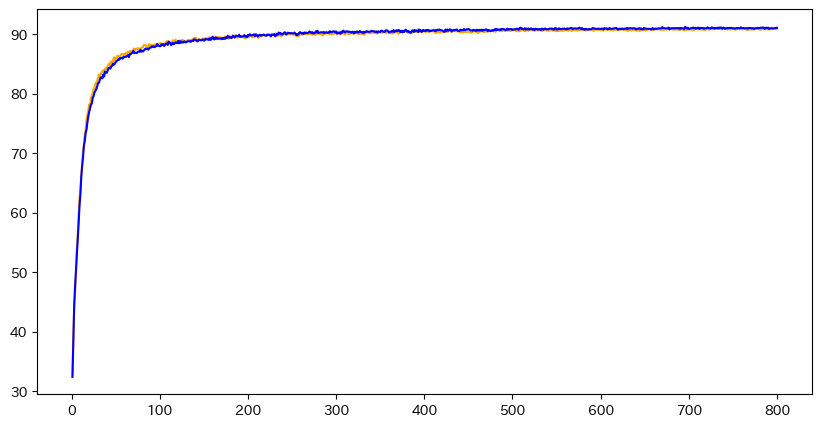

In [3]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 新しい図を作成
plt.figure(figsize=(10, 5))

# グラフごとに色を指定
colors = ["orange", "blue"]

labels = [
    "ASHAによる枝刈りありで検証用データに最適化したグラフ",
    "全ての損失関数をKLダイバージェンスに変更したグラフ",
    "全ての自己教師あり学習手法をSimCLRに変更したグラフ",
]

for i, t in enumerate(["best", "kl", "simclr"]):
    num_nodes = 7
    study_name = f"{t}_{num_nodes}"
    optuna_dir = f"optuna/{study_name}"
    transforms = "DINO"
    projector = "SwAV"
    storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
    study = optuna.create_study(
        storage=storage,
        study_name=study_name,
        load_if_exists=True,
    )
    study_df = study.trials_dataframe()
    complete_df = study_df[study_df.state == "COMPLETE"]
    sorted_df = complete_df.sort_values(by="value", ascending=False)
    top = 0
    top_series = sorted_df.iloc[top]
    models = sorted(list(filter(lambda x: "model" in x, top_series.keys())))
    ssls = sorted(list(filter(lambda x: "ssl" in x, top_series.keys())))
    model_id = 0

    accumulator = EventAccumulator(
        f"runs/{study_name}/{projector}/{transforms}/{top_series.number:04}/{model_id}_{top_series[models[model_id]]}_{top_series[ssls[model_id]]}/"
    )
    accumulator.Reload()
    wall_times, steps, values = extract_scalar_arrays(accumulator.Scalars("test_top1"))

    # プロットを追加
    plt.plot(steps, values, label=labels[i], color=colors[i])

# 180エポックあたりに垂直線を追加
plt.axvline(x=180, color="red", linestyle="--", linewidth=3)

# グラフ上部にテキストを追加
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.7)
plt.text(
    -23,
    92,
    "前半部分は最適化した\nグラフの性能が良い",
    fontsize=12,
    color="black",
    bbox=bbox_props,
)

# 下部にまとめを追加
plt.text(
    80,
    77,
    "最適ではないが，探索時間を削減しながら比較的良い性能を示すグラフを獲得できた．",
    fontsize=12,
    color="red",
)

# タイトルや軸ラベルを追加
plt.title(
    "7ノードの自己教師あり知識転移グラフにおける\nCIFAR-10（テストデータ）に対する k-NN正解率"
)
plt.xlabel("エポック")
plt.ylabel("k-NN正解率[%]")
plt.ylim(80, 95)
plt.legend()
plt.grid(True)
plt.savefig("test-top1-plot.svg", format="svg", bbox_inches="tight")
plt.show()